# Starbucks Capstone Challenge - Predictive and Modelling

## Introduction

Offer Selection

* Remove unsuccessful offers
* Strip the ID and perform a classifier

Receives Offer or Not

* Receives offer if, offer successful and total spent is 20 (10 from promo, + additional product) 

Combination of both will give better results in incremental profit and IRR.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sb_capstone.wrangling import (
    clean_transcript_group,
    tukey_rule
)

from sb_capstone.graph import (
    plot_corr    
)

from sb_capstone.shaping import (
    convert_for_training
)

%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
0,1,2,48.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2017,2,12
1,2,2,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,F,55.0,boomers,middle_age,112000.0,2017,7,15
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
3,4,2,26.000000,True,True,True,True,19.67,0.0,29.72,...,True,True,F,75.0,silent,old,100000.0,2017,5,9
4,5,2,49.866737,False,False,False,True,0.00,0.0,3.50,...,False,False,U,NaN,NaN,NaN,NaN,2017,8,4


In [4]:
transcript_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 102000 non-null  int64   
 1   wave               102000 non-null  int64   
 2   diffs              102000 non-null  float64 
 3   received           102000 non-null  bool    
 4   viewed             102000 non-null  bool    
 5   completed          102000 non-null  bool    
 6   purchased          102000 non-null  bool    
 7   amount             102000 non-null  float64 
 8   reward             102000 non-null  float64 
 9   non_offer_amount   102000 non-null  float64 
 10  mapped_offer       102000 non-null  category
 11  spendings          102000 non-null  float64 
 12  recommended_offer  102000 non-null  int64   
 13  offer_type         102000 non-null  category
 14  difficulty         102000 non-null  float64 
 15  duration           102000 non-null

## Q3. How can we make use of the result to improve the app using machine learning?

Based on our analysis, we found out that giving out these offers randomly can make customers spends more, however, only the discount revenue are the ones providing us revenue. On the other hand, the offers themselves are not good enough to improve customer's response to avail the offer.

Let's look at how we can is to distinguish which demographic are affected by the offers and to those who still spends for the product without the offer.

In [5]:
transcript_group[transcript_group.id == 3]

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
17002,3,3,49.866737,False,False,False,True,0.00,0.0,1.64,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
34002,3,4,49.866737,False,False,False,True,0.00,0.0,5.09,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
51002,3,5,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
68002,3,6,64.000000,True,False,True,False,2.14,0.0,4.09,...,True,True,U,NaN,NaN,NaN,NaN,2018,7,12
85002,3,1,49.866737,False,False,False,True,0.00,0.0,1.34,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12


Let's analyze a bit who should be given out with offers.

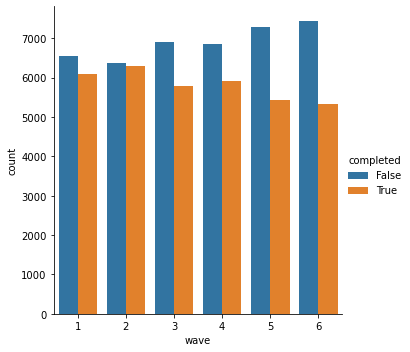

In [6]:
sns.catplot(data=transcript_group[transcript_group.received], kind="count", x="wave", hue="completed");

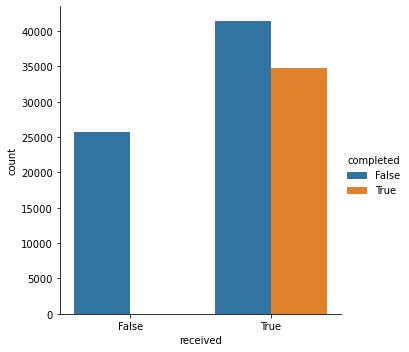

In [7]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="completed");

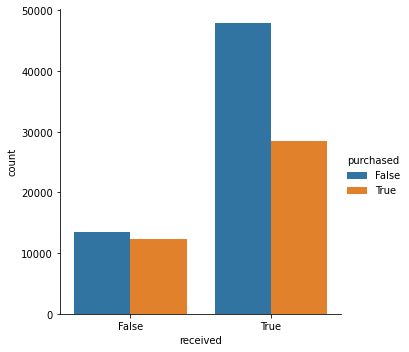

In [8]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="purchased");

In [9]:
data = convert_for_training(transcript_group.copy())
data.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,no_offer,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
0,1,2,48.000000,1,1,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,2,2,49.866737,0,0,0,0,0.00,0.0,0.00,...,1,0,0,0,1,0,0,0,1,0
2,3,2,36.000000,1,1,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
3,4,2,26.000000,1,1,1,1,19.67,0.0,29.72,...,0,0,0,0,0,1,0,0,0,1
4,5,2,49.866737,0,0,0,1,0.00,0.0,3.50,...,1,0,0,0,0,0,0,0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 102000 non-null  int64  
 1   wave               102000 non-null  int64  
 2   diffs              102000 non-null  float64
 3   received           102000 non-null  int32  
 4   viewed             102000 non-null  int32  
 5   completed          102000 non-null  int32  
 6   purchased          102000 non-null  int32  
 7   amount             102000 non-null  float64
 8   reward             102000 non-null  float64
 9   non_offer_amount   102000 non-null  float64
 10  spendings          102000 non-null  float64
 11  recommended_offer  102000 non-null  int64  
 12  difficulty         102000 non-null  float64
 13  duration           102000 non-null  float64
 14  web                102000 non-null  int32  
 15  email              102000 non-null  int32  
 16  mo

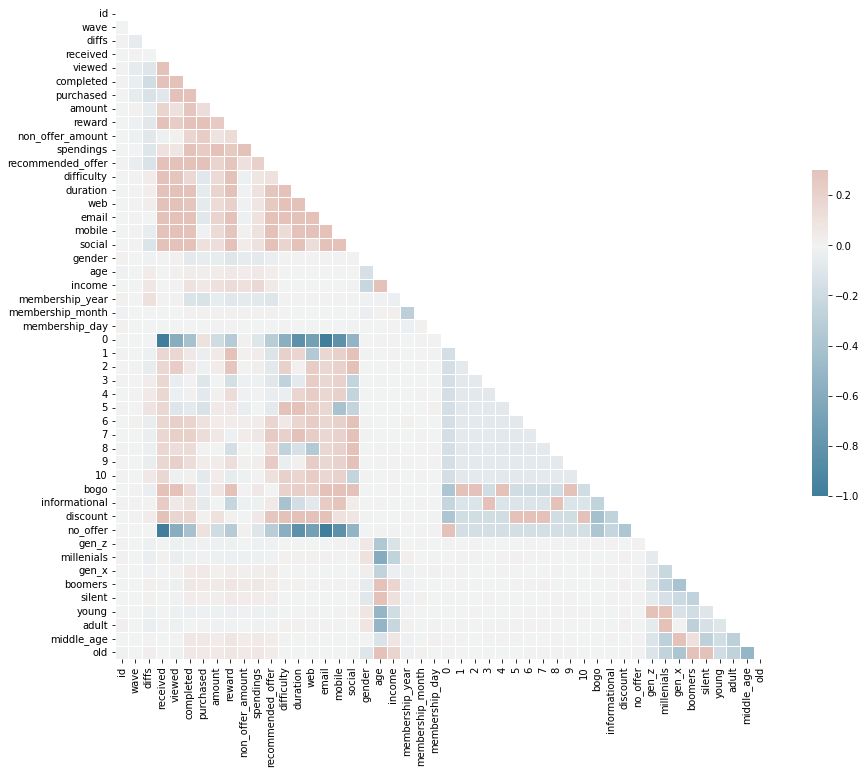

In [11]:
plot_corr(data.corr())

In [12]:
data[data.received == 1].id.nunique()

16994

### Part 1: Who should be given out with offers?

For the first part, we need things that relates to the customer, as we are going try to check if the customer may respond to the offer. At this point, we are just going to respond based on the demography of the customer.

Also, it'll be useless to add the anonymous customers for our training data, so we are going to remove them as well.

Aside from that, we are also going to limit the data to those who received offer only and how they reacted to it. This way we'll now if it's effective or not.

In [13]:
cols = [
    "purchased",
    "gender",
    "age",
    "income",
    "membership_year",
    "membership_month",
    "membership_day",
    "gen_z",
    "millenials",
    "gen_x",
    "boomers",
    "silent",
    "young",
    "adult",
    "middle_age",
    "old"
]

data = data[~data.age.isna() & data.received][cols]

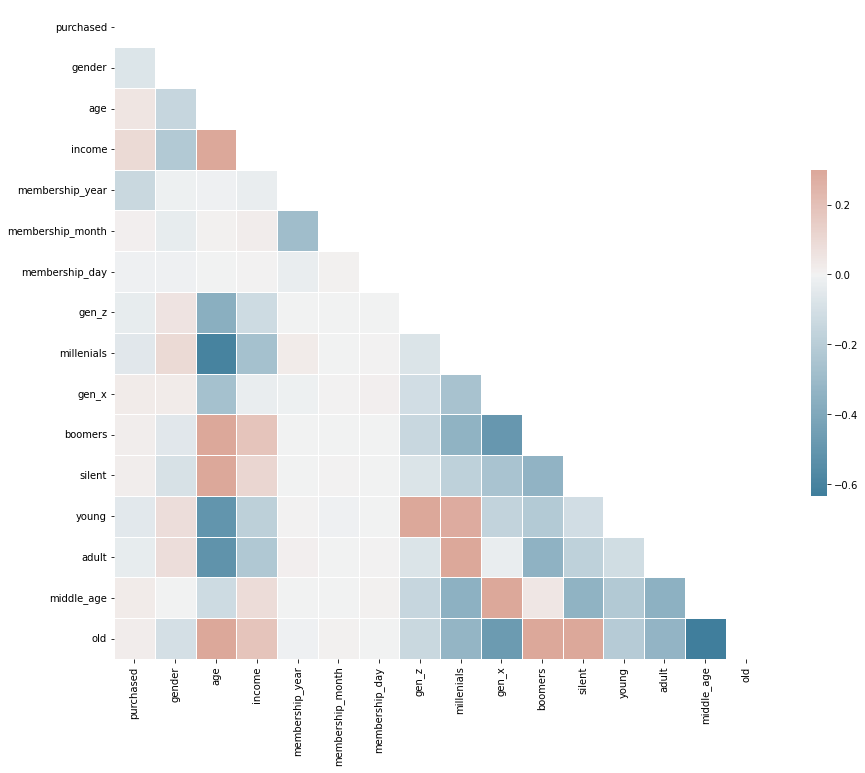

In [14]:
plot_corr(data.corr())

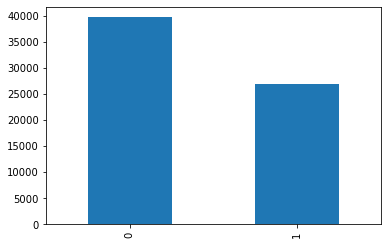

In [15]:
data.purchased.value_counts().plot(kind="bar");

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy="most_frequent")
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [17]:
data.head()

,purchased,gender,age,income,membership_year,membership_month,membership_day,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
0,1.0,0.0,75.0,100000.0,2017.0,5.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,65.0,53000.0,2018.0,2.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,58.0,51000.0,2017.0,11.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,61.0,57000.0,2017.0,9.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,26.0,46000.0,2014.0,2.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   purchased         66501 non-null  float64
 1   gender            66501 non-null  float64
 2   age               66501 non-null  float64
 3   income            66501 non-null  float64
 4   membership_year   66501 non-null  float64
 5   membership_month  66501 non-null  float64
 6   membership_day    66501 non-null  float64
 7   gen_z             66501 non-null  float64
 8   millenials        66501 non-null  float64
 9   gen_x             66501 non-null  float64
 10  boomers           66501 non-null  float64
 11  silent            66501 non-null  float64
 12  young             66501 non-null  float64
 13  adult             66501 non-null  float64
 14  middle_age        66501 non-null  float64
 15  old               66501 non-null  float64
dtypes: float64(16)
memory usage: 8.1 MB


We are going to use a simple logistic regression for this one using `purchased` as response variable.

In [19]:
from sklearn.model_selection import train_test_split

y = data.purchased
X = data.drop(columns=["purchased"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [21]:
from sklearn.metrics import classification_report

y_true = lr.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.59      0.73     16039
         1.0       0.04      0.44      0.07       587

    accuracy                           0.59     16626
   macro avg       0.50      0.52      0.40     16626
weighted avg       0.93      0.59      0.71     16626



Let's feed this to `GridSearchCV`.

In [22]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("clf", LogisticRegression())
])

After trial and error, I selected the top 3 algorithms that yield best results. For this instance, we'll make use of F1-score as this a balance between precision and recall.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

parameters_clf = {
    "clf": [
        LogisticRegression(),
        DecisionTreeClassifier(),
        KNeighborsClassifier()
    ]
}

In [24]:
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(pipeline, parameters_clf, verbose=1)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'clf': DecisionTreeClassifier()}


In [25]:
y_true = cv.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71     11615
         1.0       0.41      0.56      0.48      5011

    accuracy                           0.63     16626
   macro avg       0.59      0.61      0.59     16626
weighted avg       0.67      0.63      0.64     16626



In [26]:
joblib.dump(cv, "../models/receive_offer.pkl")

['../models/receive_offer.pkl']

We'll make use of this model later with our library.

### Part 2: Which offer should we give out?

Examining the current data that we have, this can be answered by creating a recommendation system for the customer. However, we are going to make use of the customer features and try to classify which offer fits best.

With this we need to perform the following first.
* We need to flatten further the dataset and get the best offer (including non-offer)
* Best offer will based on which is successful and yields the highest spendings among the offers
* Revenue will be based:
    * If not received any offer, spendings is the total `non_offer_amount`
    * If received offer, but `purchased` failed, classification is still `non_offer` and spendings is `non_offer_amount`
    * If received offer, and `purchased` is successful, classification is `offer` and spendings is `offer_amount` + `non_offer_amount` as we are assuming that the purchase was influenced by the promotion.

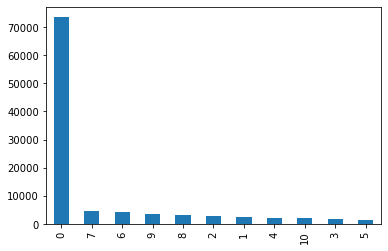

In [27]:
transcript_group.recommended_offer.value_counts().plot(kind="bar");

In [28]:
transcript_group.spendings.describe()

count    102000.000000
mean         17.406392
std          41.437611
min           0.000000
25%           0.000000
50%           5.750000
75%          22.670000
max        1136.780000
Name: spendings, dtype: float64

In [29]:
transcript_group.gender.value_counts()

M    50904
F    36774
U    13050
O     1272
Name: gender, dtype: int64

We do see some outliers in the data, and also, some customers who opt-out giving their information, we need to perform some cleaning first before we can perform our model training.

In [30]:
data = transcript_group.copy()
data = data[~data.age.isna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88950 entries, 1 to 101999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 88950 non-null  int64   
 1   wave               88950 non-null  int64   
 2   diffs              88950 non-null  float64 
 3   received           88950 non-null  bool    
 4   viewed             88950 non-null  bool    
 5   completed          88950 non-null  bool    
 6   purchased          88950 non-null  bool    
 7   amount             88950 non-null  float64 
 8   reward             88950 non-null  float64 
 9   non_offer_amount   88950 non-null  float64 
 10  mapped_offer       88950 non-null  category
 11  spendings          88950 non-null  float64 
 12  recommended_offer  88950 non-null  int64   
 13  offer_type         88950 non-null  category
 14  difficulty         88950 non-null  float64 
 15  duration           88950 non-null  float64 
 16  web

Let's use `tukey_rule` to remove outliers.

In [31]:
data = tukey_rule(data, "spendings")
data.spendings.describe()

count    83884.000000
mean        13.307502
std         15.991520
min          0.000000
25%          0.000000
50%          6.840000
75%         22.160000
max         63.960000
Name: spendings, dtype: float64

Still a good sample size. Now we need to compress the data and select the fields that only relates to the customer.

In [32]:
data.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
1,2,2,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,F,55.0,boomers,middle_age,112000.0,2017,7,15
3,4,2,26.000000,True,True,True,True,19.67,0.0,29.72,...,True,True,F,75.0,silent,old,100000.0,2017,5,9
5,6,2,49.866737,False,False,False,True,0.00,0.0,39.31,...,False,False,M,68.0,boomers,old,70000.0,2018,4,26
8,9,2,66.000000,True,True,True,True,0.00,5.0,0.00,...,True,False,M,65.0,boomers,old,53000.0,2018,2,9
12,13,2,108.000000,True,True,False,False,2.32,0.0,0.00,...,True,True,M,58.0,boomers,middle_age,51000.0,2017,11,11


In [33]:
data.dtypes

id                      int64
wave                    int64
diffs                 float64
received                 bool
viewed                   bool
completed                bool
purchased                bool
amount                float64
reward                float64
non_offer_amount      float64
mapped_offer         category
spendings             float64
recommended_offer       int64
offer_type           category
difficulty            float64
duration              float64
web                      bool
email                    bool
mobile                   bool
social                   bool
gender               category
age                   float64
generation           category
group                category
income                float64
membership_year         int64
membership_month        int64
membership_day          int64
dtype: object

In [34]:
data = data.sort_values("spendings", ascending=False).groupby("id").first().reset_index()

In [35]:
cols = [
    "spendings",
    "recommended_offer",
    "gender",
    "age",
    "generation",
    "group",
    "income"
]

data = data[cols]

We are going to convert this to a trainable dataset, using recommended offer as our response variable.

In [36]:
data.gender.value_counts()

M    8484
F    6129
O     212
U       0
Name: gender, dtype: int64

We have unspecified here. We don't want to be binary with regards to gender, so let's honor the `Other` gender. With values more than 3, we're going to dummify this.

In [37]:
data = pd.concat([data, pd.get_dummies(data.gender).drop(columns=["U"])], axis=1).drop(columns="gender")
data.head()

,spendings,recommended_offer,age,generation,group,income,F,M,O
0,53.79,0,55.0,boomers,middle_age,112000.0,1,0,0
1,49.39,8,75.0,silent,old,100000.0,1,0,0
2,39.31,0,68.0,boomers,old,70000.0,0,1,0
3,15.63,0,65.0,boomers,old,53000.0,0,1,0
4,12.43,7,58.0,boomers,middle_age,51000.0,0,1,0


In [38]:
data = pd.concat([data, pd.get_dummies(data.group)], axis=1).drop(columns="group")
data.head()

,spendings,recommended_offer,age,generation,income,F,M,O,young,adult,middle_age,old
0,53.79,0,55.0,boomers,112000.0,1,0,0,0,0,1,0
1,49.39,8,75.0,silent,100000.0,1,0,0,0,0,0,1
2,39.31,0,68.0,boomers,70000.0,0,1,0,0,0,0,1
3,15.63,0,65.0,boomers,53000.0,0,1,0,0,0,0,1
4,12.43,7,58.0,boomers,51000.0,0,1,0,0,0,1,0


In [39]:
data = pd.concat([data, pd.get_dummies(data.generation)], axis=1).drop(columns="generation")
data.head()

,spendings,recommended_offer,age,income,F,M,O,young,adult,middle_age,old,gen_z,millenials,gen_x,boomers,silent
0,53.79,0,55.0,112000.0,1,0,0,0,0,1,0,0,0,0,1,0
1,49.39,8,75.0,100000.0,1,0,0,0,0,0,1,0,0,0,0,1
2,39.31,0,68.0,70000.0,0,1,0,0,0,0,1,0,0,0,1,0
3,15.63,0,65.0,53000.0,0,1,0,0,0,0,1,0,0,0,1,0
4,12.43,7,58.0,51000.0,0,1,0,0,0,1,0,0,0,0,1,0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spendings          14825 non-null  float64
 1   recommended_offer  14825 non-null  int64  
 2   age                14825 non-null  float64
 3   income             14825 non-null  float64
 4   F                  14825 non-null  uint8  
 5   M                  14825 non-null  uint8  
 6   O                  14825 non-null  uint8  
 7   young              14825 non-null  uint8  
 8   adult              14825 non-null  uint8  
 9   middle_age         14825 non-null  uint8  
 10  old                14825 non-null  uint8  
 11  gen_z              14825 non-null  uint8  
 12  millenials         14825 non-null  uint8  
 13  gen_x              14825 non-null  uint8  
 14  boomers            14825 non-null  uint8  
 15  silent             14825 non-null  uint8  
dtypes: float64(3), int64(1

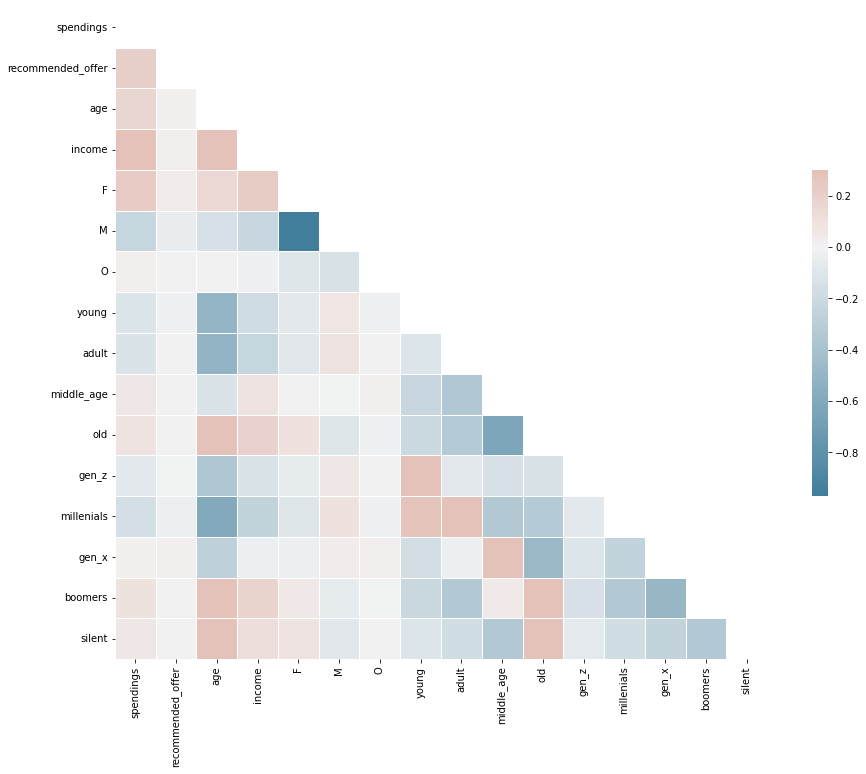

In [41]:
plot_corr(data.corr())

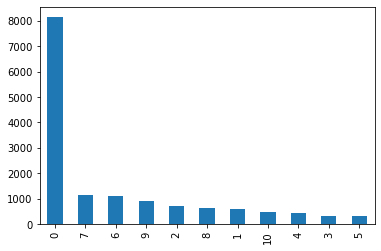

In [42]:
data.recommended_offer.value_counts().plot(kind="bar");

In [43]:
y = data.recommended_offer
X = data.drop(columns="recommended_offer")

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
clf = LogisticRegression(multi_class="multinomial")
clf.fit(X_train, y_train)


LogisticRegression(multi_class='multinomial')

In [45]:
y_true = clf.predict(X_test)

print(classification_report(y_true, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      3620
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.00      1.00      0.00         0
           6       0.00      1.00      0.00         0
           7       0.03      0.09      0.04        87
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0

    accuracy                           0.55      3707
   macro avg       0.09      0.88      0.07      3707
weighted avg       0.97      0.55      0.70      3707



Bad algorithm to use, we can see that most of the predictions are zero or `no_offer`, and only 79 of those, recommended offer 7. Let's feed it in a `GridSearchCV`.

In [46]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([
    ("clf", LogisticRegression())
])

parameters_clf = {
    "clf": [
        LogisticRegression(multi_class="multinomial", class_weight="balanced")
        #SVC(decision_function_shape="ovo", class_weight="balanced"),
        #RandomForestClassifier(class_weight="balanced"),
        #KNeighborsClassifier()
    ]
}

In [47]:
cv = GridSearchCV(pipeline, parameters_clf, verbose=1)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'clf': LogisticRegression(class_weight='balanced', multi_class='multinomial')}


In [48]:
y_true = clf.predict(X_test)
print(classification_report(y_true, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      3620
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.00      1.00      0.00         0
           6       0.00      1.00      0.00         0
           7       0.03      0.09      0.04        87
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0

    accuracy                           0.55      3707
   macro avg       0.09      0.88      0.07      3707
weighted avg       0.97      0.55      0.70      3707



In [49]:
transcript_group.dtypes

id                      int64
wave                    int64
diffs                 float64
received                 bool
viewed                   bool
completed                bool
purchased                bool
amount                float64
reward                float64
non_offer_amount      float64
mapped_offer         category
spendings             float64
recommended_offer       int64
offer_type           category
difficulty            float64
duration              float64
web                      bool
email                    bool
mobile                   bool
social                   bool
gender               category
age                   float64
generation           category
group                category
income                float64
membership_year         int64
membership_month        int64
membership_day          int64
dtype: object

In [50]:
data = transcript_group[transcript_group.recommended_offer != 0].groupby("id").agg({
    "recommended_offer": lambda x: list(dict.fromkeys(x.tolist())),
    "spendings": "mean",
    "diffs": "mean",
    "gender": "first",
    "age": "max",
    "generation": "first",
    "group": "first",
    "income": "max",
    "membership_year": "max",
    "membership_month": "max",
    "membership_day": "max"
}).reset_index()

data.head()

,id,recommended_offer,spendings,diffs,gender,age,generation,group,income,membership_year,membership_month,membership_day
0,1,"[7, 6]",5.085,27.500000,U,NaN,NaN,NaN,NaN,2017,2,12
1,4,"[8, 1, 4]",29.020,40.666667,F,75.0,silent,old,100000.0,2017,5,9
2,6,"[4, 7]",9.210,46.500000,M,68.0,boomers,old,70000.0,2018,4,26
3,9,"[4, 10, 9, 7]",4.160,49.000000,M,65.0,boomers,old,53000.0,2018,2,9
4,11,[1],59.880,28.500000,U,NaN,NaN,NaN,NaN,2017,8,24


In [51]:
data = data[~data.age.isna()]

In [52]:
offers = pd.get_dummies(data.recommended_offer.explode()).groupby(level=0).sum()
offers.columns = offers.columns.astype(str)

data = pd.concat([data, offers], axis=1).drop(columns="recommended_offer")
data.head()

,id,spendings,diffs,gender,age,generation,group,income,membership_year,membership_month,...,1,2,3,4,5,6,7,8,9,10
1,4,29.020,40.666667,F,75.0,silent,old,100000.0,2017,5,...,1,0,0,1,0,0,0,1,0,0
2,6,9.210,46.500000,M,68.0,boomers,old,70000.0,2018,4,...,0,0,0,1,0,0,1,0,0,0
3,9,4.160,49.000000,M,65.0,boomers,old,53000.0,2018,2,...,0,0,0,1,0,0,1,0,1,1
6,13,12.430,60.000000,M,58.0,boomers,middle_age,51000.0,2017,11,...,0,0,0,0,0,0,1,0,0,0
7,14,12.445,67.000000,F,61.0,boomers,old,57000.0,2017,9,...,0,1,0,0,0,0,0,0,1,0


In [58]:
data = pd.concat([data, pd.get_dummies(data.gender).drop(columns="U")], axis=1).drop(columns="gender")
data.head()

,id,spendings,diffs,age,generation,group,income,membership_year,membership_month,membership_day,...,4,5,6,7,8,9,10,F,M,O
1,4,29.020,40.666667,75.0,silent,old,100000.0,2017,5,9,...,1,0,0,0,1,0,0,1,0,0
2,6,9.210,46.500000,68.0,boomers,old,70000.0,2018,4,26,...,1,0,0,1,0,0,0,0,1,0
3,9,4.160,49.000000,65.0,boomers,old,53000.0,2018,2,9,...,1,0,0,1,0,1,1,0,1,0
6,13,12.430,60.000000,58.0,boomers,middle_age,51000.0,2017,11,11,...,0,0,0,1,0,0,0,0,1,0
7,14,12.445,67.000000,61.0,boomers,old,57000.0,2017,9,11,...,0,0,0,0,0,1,0,1,0,0


In [62]:
data = pd.concat([data, pd.get_dummies(data.generation)], axis=1).drop(columns="generation")
data.head()

,id,spendings,diffs,age,group,income,membership_year,membership_month,membership_day,1,...,9,10,F,M,O,gen_z,millenials,gen_x,boomers,silent
1,4,29.020,40.666667,75.0,old,100000.0,2017,5,9,1,...,0,0,1,0,0,0,0,0,0,1
2,6,9.210,46.500000,68.0,old,70000.0,2018,4,26,0,...,0,0,0,1,0,0,0,0,1,0
3,9,4.160,49.000000,65.0,old,53000.0,2018,2,9,0,...,1,1,0,1,0,0,0,0,1,0
6,13,12.430,60.000000,58.0,middle_age,51000.0,2017,11,11,0,...,0,0,0,1,0,0,0,0,1,0
7,14,12.445,67.000000,61.0,old,57000.0,2017,9,11,0,...,1,0,1,0,0,0,0,0,1,0


In [65]:
data = pd.concat([data, pd.get_dummies(data.group)], axis=1).drop(columns="group")
data.head()

,id,spendings,diffs,age,income,membership_year,membership_month,membership_day,1,2,...,O,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
1,4,29.020,40.666667,75.0,100000.0,2017,5,9,1,0,...,0,0,0,0,0,1,0,0,0,1
2,6,9.210,46.500000,68.0,70000.0,2018,4,26,0,0,...,0,0,0,0,1,0,0,0,0,1
3,9,4.160,49.000000,65.0,53000.0,2018,2,9,0,0,...,0,0,0,0,1,0,0,0,0,1
6,13,12.430,60.000000,58.0,51000.0,2017,11,11,0,0,...,0,0,0,0,1,0,0,0,1,0
7,14,12.445,67.000000,61.0,57000.0,2017,9,11,0,1,...,0,0,0,0,1,0,0,0,0,1


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11763 entries, 1 to 12803
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                11763 non-null  int64  
 1   spendings         11763 non-null  float64
 2   diffs             11763 non-null  float64
 3   age               11763 non-null  float64
 4   income            11763 non-null  float64
 5   membership_year   11763 non-null  int64  
 6   membership_month  11763 non-null  int64  
 7   membership_day    11763 non-null  int64  
 8   1                 11763 non-null  uint8  
 9   2                 11763 non-null  uint8  
 10  3                 11763 non-null  uint8  
 11  4                 11763 non-null  uint8  
 12  5                 11763 non-null  uint8  
 13  6                 11763 non-null  uint8  
 14  7                 11763 non-null  uint8  
 15  8                 11763 non-null  uint8  
 16  9                 11763 non-null  uint8 

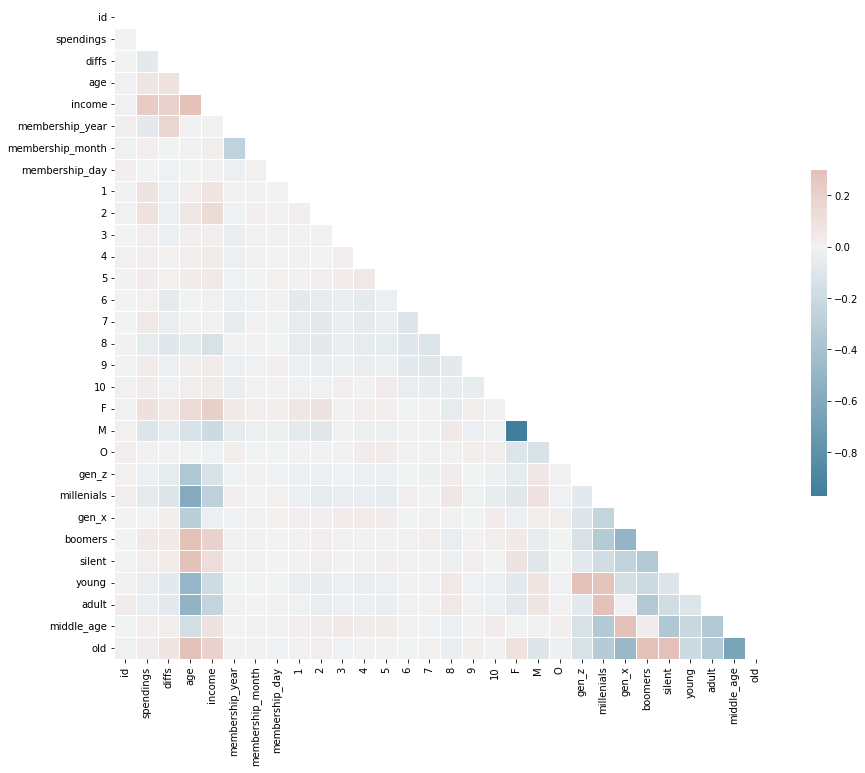

In [67]:
plot_corr(data.corr())

In [77]:
y_cols = np.arange(1, 11).astype(str).tolist()

y = data[y_cols]
X = data[data.columns[~data.columns.isin(y_cols)]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

len(X_train), len(X_test)

(8822, 2941)

In [78]:
from sklearn.multioutput import MultiOutputClassifier

clf = MultiOutputClassifier(KNeighborsClassifier())
clf.fit(X, y)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [80]:
y_pred = clf.predict(X_test)

print(classification_report(y_pred, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.17      0.64      0.27       157
           1       0.24      0.63      0.35       228
           2       0.10      0.62      0.17        53
           3       0.12      0.56      0.20       104
           4       0.06      0.63      0.11        30
           5       0.36      0.67      0.47       508
           6       0.38      0.62      0.47       571
           7       0.24      0.63      0.35       249
           8       0.25      0.61      0.35       317
           9       0.16      0.63      0.26       121

   micro avg       0.24      0.63      0.35      2338
   macro avg       0.21      0.62      0.30      2338
weighted avg       0.28      0.63      0.38      2338
 samples avg       0.25      0.77      0.29      2338



In [87]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC

pipeline = Pipeline([
    ("clf", MultiOutputClassifier(estimator=KNeighborsClassifier()))
])

parameters_clf = {
    "clf__estimator": [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier()
    ]
}

cv = GridSearchCV(pipeline, parameters_clf, verbose=5)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END clf__estimator=KNeighborsClassifier();, score=0.022 total time=   2.1s
[CV 2/5] END clf__estimator=KNeighborsClassifier();, score=0.028 total time=   2.1s
[CV 3/5] END clf__estimator=KNeighborsClassifier();, score=0.031 total time=   2.0s
[CV 4/5] END clf__estimator=KNeighborsClassifier();, score=0.032 total time=   2.1s
[CV 5/5] END clf__estimator=KNeighborsClassifier();, score=0.027 total time=   2.1s
[CV 1/5] END clf__estimator=DecisionTreeClassifier();, score=0.026 total time=   0.3s
[CV 2/5] END clf__estimator=DecisionTreeClassifier();, score=0.028 total time=   0.4s
[CV 3/5] END clf__estimator=DecisionTreeClassifier();, score=0.023 total time=   0.3s
[CV 4/5] END clf__estimator=DecisionTreeClassifier();, score=0.030 total time=   0.3s
[CV 5/5] END clf__estimator=DecisionTreeClassifier();, score=0.021 total time=   0.4s
[CV 1/5] END clf__estimator=ExtraTreeClassifier();, score=0.021 total time=   0.0s
[CV 2/5

GridSearchCV(estimator=Pipeline(steps=[('clf',
                                        MultiOutputClassifier(estimator=KNeighborsClassifier()))]),
             param_grid={'clf__estimator': [KNeighborsClassifier(),
                                            DecisionTreeClassifier(),
                                            ExtraTreeClassifier()]},
             verbose=5)

In [90]:
parameters_kn = {
    "clf__estimator__n_neighbors": [1, 3, 5, 7, 9]
}

cv = GridSearchCV(pipeline, parameters_kn, verbose=5)
cv.fit(X_train, y_train)

print(cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....clf__estimator__n_neighbors=1;, score=0.031 total time=   1.3s
[CV 2/5] END .....clf__estimator__n_neighbors=1;, score=0.027 total time=   1.4s
[CV 3/5] END .....clf__estimator__n_neighbors=1;, score=0.032 total time=   1.3s
[CV 4/5] END .....clf__estimator__n_neighbors=1;, score=0.025 total time=   1.3s
[CV 5/5] END .....clf__estimator__n_neighbors=1;, score=0.020 total time=   1.4s
[CV 1/5] END .....clf__estimator__n_neighbors=3;, score=0.036 total time=   1.7s
[CV 2/5] END .....clf__estimator__n_neighbors=3;, score=0.032 total time=   1.7s
[CV 3/5] END .....clf__estimator__n_neighbors=3;, score=0.033 total time=   1.6s
[CV 4/5] END .....clf__estimator__n_neighbors=3;, score=0.029 total time=   1.6s
[CV 5/5] END .....clf__estimator__n_neighbors=3;, score=0.034 total time=   1.6s
[CV 1/5] END .....clf__estimator__n_neighbors=5;, score=0.022 total time=   2.1s
[CV 2/5] END .....clf__estimator__n_neighbors=5;,

In [92]:
y_pred = cv.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.19      0.09      0.12       595
           1       0.24      0.14      0.18       593
           2       0.12      0.04      0.06       329
           3       0.18      0.08      0.11       488
           4       0.08      0.02      0.03       313
           5       0.32      0.21      0.25       945
           6       0.31      0.25      0.27       932
           7       0.23      0.13      0.17       638
           8       0.24      0.15      0.18       777
           9       0.16      0.09      0.11       461

   micro avg       0.25      0.14      0.18      6071
   macro avg       0.21      0.12      0.15      6071
weighted avg       0.23      0.14      0.17      6071
 samples avg       0.41      0.15      0.15      6071



In [93]:
joblib.dump(cv, "../models/select_offer.pkl")

['../models/select_offer.pkl']